# Distribution of minimum central pressure

We examine the distribution of minimum central pressure, and it's time of occurrence in the lifetime of the TC. We aim to identify the most common period of maximum lifetime intensity, and whether this corresponds to the observations of (anti-)correlation in the pressure rate of change at $t=48$ to $t=96$ hours. 

In [1]:
%matplotlib inline

from __future__ import print_function, division

import io
import os
import sys
import numpy as np
import numpy.ma as ma
from os.path import join as pjoin

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from scipy.stats import pearsonr, betai, weibull_max, gumbel_l, lognorm, norm, weibull_min, nct, exponnorm


from Utilities.config import ConfigParser
from Utilities.loadData import loadTrackFile
from Utilities.config import ConfigParser
from Utilities.track import Track
from Utilities.metutils import convert

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

In [2]:
configstr = """
[DataProcess]
InputFile=/home/tcrm/data/Allstorms.ibtracs_wmo.v03r09.csv
Source=IBTRACS
StartSeason=1981
FilterSeasons=True

[Region]
; Domain for windfield and hazard calculation
gridLimit={'xMin':90.,'xMax':180.,'yMin':-30.0,'yMax':-5.0}
gridSpace={'x':1.0,'y':1.0}
gridInc={'x':1.0,'y':0.5}

[TrackGenerator]
NumSimulations=5000
YearsPerSimulation=10
SeasonSeed=68876543
TrackSeed=334825
TimeStep=1.0

[Input]
landmask = /home/tcrm/tcrm/input/landmask.nc
mslpfile = /home/tcrm/tcrm/MSLP/slp.day.ltm.nc
datasets = IBTRACS,LTMSLP

[Output]
Path=/media/sf_share/tcrm/fiji

[Hazard]
Years=2,5,10,20,25,50,100,200,250,500,1000,2000,2500,5000
MinimumRecords=10
CalculateCI=False

[Logging]
LogFile=/media/sf_share/tcrm/fiji/log/fiji.log
LogLevel=INFO
Verbose=False

[IBTRACS]
; Input data file settings
url = ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r09/wmo/csv/Allstorms.ibtracs_wmo.v03r09.csv.gz
path = /home/tcrm/data
filename = Allstorms.ibtracs_wmo.v03r09.csv
columns = tcserialno,season,num,skip,skip,skip,date,skip,lat,lon,skip,pressure
fielddelimiter = ,
numberofheadinglines = 3
pressureunits = hPa
lengthunits = km
dateformat = %Y-%m-%d %H:%M:%S
speedunits = kph

[LTMSLP]
; MSLP climatology file settings
URL = ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.day.1981-2010.ltm.nc
path = /home/tcrm/tcrm/MSLP
filename = slp.day.ltm.nc"""

In [3]:
config = ConfigParser()
config.readfp(io.BytesIO(configstr))

In [4]:
trackFile = config.get('DataProcess', 'InputFile')
source = config.get('DataProcess', 'Source')

print("Track file: {0}".format(trackFile))
print("Track format: {0}".format(source))
alltracks = loadTrackFile(configstr, trackFile, source)
#tracks = parseTracks(configstr, trackFile, source, 1.)

gridLimit=config.geteval('Region', 'gridLimit')

tracks = [track for track in alltracks if track.inRegion(gridLimit)]

print("There are {0:d} tracks in the input dataset".format(len(tracks)))

Track file: /home/tcrm/data/Allstorms.ibtracs_wmo.v03r09.csv
Track format: IBTRACS
There are 312 tracks in the input dataset


In [5]:
def getIndices(elapsedTime, delta=6, maxtime=120):
    filter1 = (np.mod(elapsedTime, delta)==0)
    filter2 = (elapsedTime<=maxtime)
    idx = np.nonzero(filter1 & filter2)
    return idx

In [9]:
ntracks = len(tracks)
ndays = 7
nhours = ndays * 24.

steps = range(6, int(nhours + 1), 6)
prsteps = range(0, int(nhours + 1), 6)
alldp = ma.zeros((int(nhours/6), ntracks))
allprs = ma.zeros((int(nhours/6) + 1, ntracks))
minprs = np.zeros(ntracks)
minprststep = np.zeros(ntracks)
for i, track in enumerate(tracks):
    minprs[i] = track.trackMinPressure
    idx = np.where(track.CentralPressure == track.trackMinPressure)
    minprststep[i] = track.TimeElapsed[idx[0][0]]
    
pmask = (minprs==0)
minprs = ma.array(minprs, mask=pmask)
minprststep = ma.array(minprststep, mask=pmask)

We plot first the histogram of minimum central pressure values. The values are often binned to the nearest 5 hPa value, so if we have a small bin, we can see this effect. 

If we modify the binning in the histogram, this effect dissipates. The good thing is, when we use a kernel density estimation method to generate a distribution, the method will essentially smooth over these local peaks and will generate a reasonable distribution.

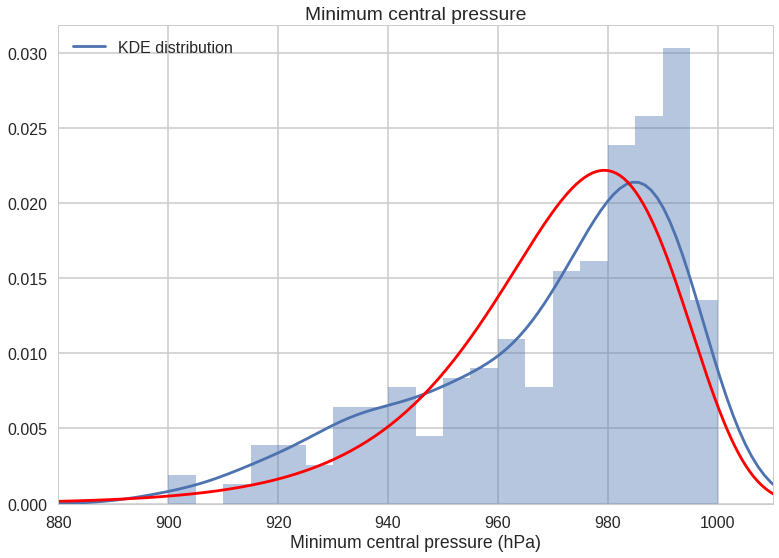

In [14]:
ax = sns.distplot(minprs.compress(minprs!=0), bins=np.arange(880, 1011, 5),
                  fit=gumbel_l,kde_kws={'label':'KDE distribution'},
                   fit_kws={"color":'r', "label":"Gumbel distribution"})
ax.set_xlim((880, 1010))
ax.set_title("Minimum central pressure")
ax.set_xlabel("Minimum central pressure (hPa)")

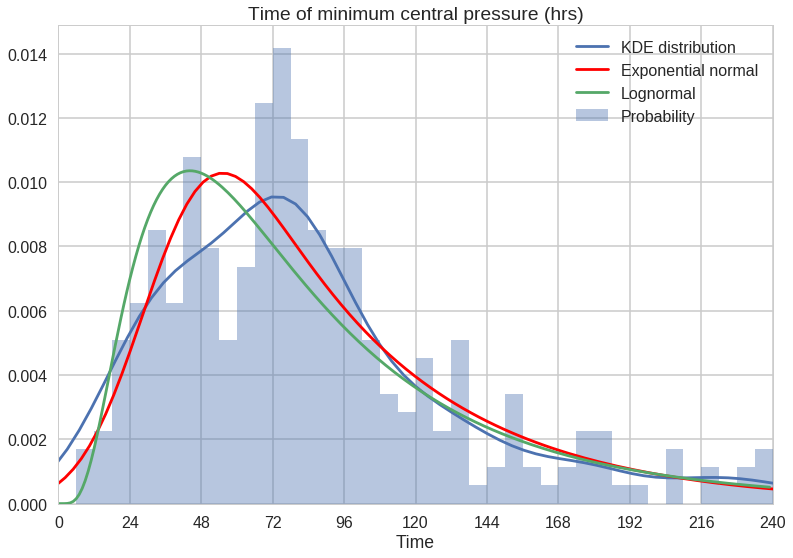

In [10]:
ax = sns.distplot(minprststep.compress(minprststep!=0), bins=np.arange(0, 241, 6), 
                  fit=exponnorm, fit_kws=dict(label='Exponential normal', color='r'),
                  kde_kws=dict(label='KDE distribution'),
                  hist_kws=dict(label='Probability'))
ax.set_xlim((0, 240))
ax.set_xticks(np.arange(0, 241, 24))
ax.set_title("Time of minimum central pressure (hrs)")
ax.set_xlabel("Time")
fp = lognorm.fit(minprststep.compress(minprststep!=0), floc=0)
ax.plot(np.arange(0, 240), lognorm.pdf(np.arange(0, 240), *fp), label='Lognormal')
ax.legend(loc=1)

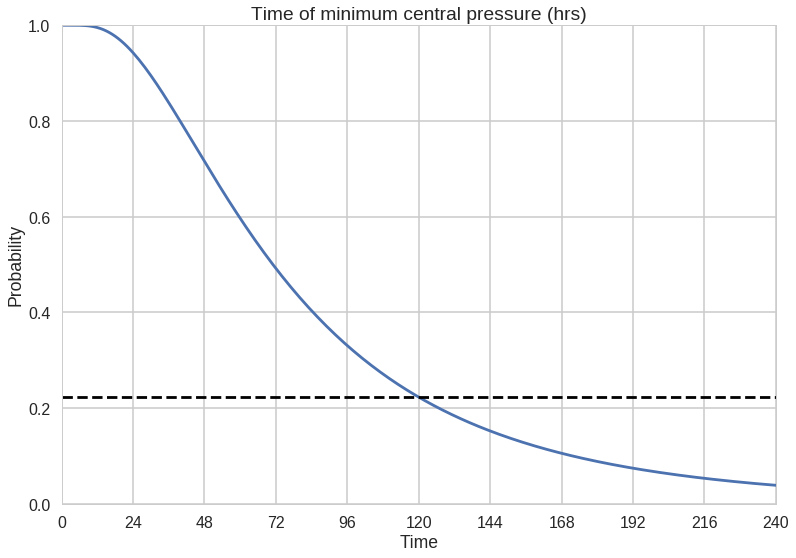

In [31]:
fig, ax = plt.subplots()
x = np.arange(0, 241, 1)
ax.plot(x, lognorm.sf(x, *fp))
ax.set_xlim((0, 240))
ax.set_xticks(np.arange(0, 241, 24))
ax.set_title("Time of minimum central pressure (hrs)")
ax.set_xlabel("Time")
ax.set_ylim((0,1))
ax.set_ylabel("Probability")
ax.axhline(lognorm.sf(120, *fp), linestyle='--', color='k')

So the observations tell us that most TCs reach peak intensity (c.f. reach minimum central pressure) around 48-72 hours after the initial observation. The likelihood of a storm achieving minimum central pressure after 120 hours is just over 20%.